<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/advectionDiffusionSource1D_FipyFiniteVolume2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy
# uncomment to install fipy then restart the runtime environment

In [2]:
import numpy as np
from fipy import *

In [3]:
# space discretization
xL = 0.
xR = 10.
dx = 0.1
delX = xR - xL
nx = int(delX/dx)
mesh = Grid1D(nx=nx, dx=dx) + xL

In [4]:
# time discretization
# advection
Cr = 0.2 # Courant Number: Cr = u*dt/dx
u = 20.
dtAdv = Cr*dx/u
# diffusion
Fr = 0.4 # Fourier Number: Fr = D*dt/dx**2
D = 4.
dtDiff = Fr*dx**2/D
# advectionDiffusion
dt = min(dtAdv, dtDiff)
print('dtAdv = ', dtAdv, '\n'
      'dtDiff = ', dtDiff, '\n'
      'dt = min(dtAdv, dtDiff) = ', dt)
# simulation time
delT = 0.3
stepsNbr = int(delT/dt)

dtAdv =  0.0010000000000000002 
dtDiff =  0.0010000000000000002 
dt = min(dtAdv, dtDiff) =  0.0010000000000000002


In [5]:
# this function returns the center of the grid cell the closest to the source position
def sourceCenter(sourcePos):
    global mesh
    x = mesh.x
    xs1 = sourcePos
    dist2Source = DistanceVariable(mesh=mesh,
                                   value=numerix.sqrt((x-xs1)**2))
    sourceClosestCellMask = (dist2Source == dist2Source.min())
    xcs, *_ = x[sourceClosestCellMask]
    return xcs

In [6]:
# this function make a selection of all the grid cells making the source
def sourceMask(xcs, width=0.):
    global mesh
    x = mesh.x
    ds = DistanceVariable(mesh=mesh,
                          value=numerix.sqrt((x-xcs)**2))
    return (ds <= width)

In [7]:
# initialization
s1Pos = (2.21,)
s1Width = 4*dx
yMin, yMax = 0., 1.

def initialize():
    # preparing the SourceTerm
    global s1Pos, s1Width, yMax
    xcs1 = sourceCenter(sourcePos=s1Pos)
    #s1Mask = sourceMask(xcs=xcs1)
    s1Mask = sourceMask(xcs=xcs1, width=s1Width)
    s1Value = yMax

    # unkown's initialization
    global mesh, yMin, yInit, y
    yInit = CellVariable(mesh=mesh, value=yMin)
    yInit.setValue(s1Value, where=s1Mask)
    y = CellVariable(mesh=mesh, value=yInit)

    # Applying noFlow BC
    y.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global u, D, eq
    eq = (TransientTerm(coeff=1.0)
       + PowerLawConvectionTerm(coeff=(u,))
       == DiffusionTerm(coeff=D)
       - ImplicitSourceTerm(s1Mask * 1e+10) + s1Mask * 1e+10 * s1Value)

In [8]:
# defining the time-step update function
def advectAndDiffuse1(y, dt):
    eq.solve(var=y, dt=dt)

In [9]:
# displaying some parameters
print('dx = ', "{:.2e}".format(dx), '\n'
      'delX = ', delX, '\n'
      'nx = ', nx, '\n'
      'Cr = ', Cr, '\n'
      'u = ', u, '\n'
      'dtAdv = ', "{:.2e}".format(dtAdv), '\n'
      'Fr = ', Fr, '\n'
      'D = ', D, '\n'
      'dtDiff = ', "{:.2e}".format(dtDiff), '\n'
      'dt = min(dtAdv,dtDiff) = ', "{:.2e}".format(dt), '\n'
      'delT = ', delT, '\n'
      'stepsNbr = ', stepsNbr)

dx =  1.00e-01 
delX =  10.0 
nx =  100 
Cr =  0.2 
u =  20.0 
dtAdv =  1.00e-03 
Fr =  0.4 
D =  4.0 
dtDiff =  1.00e-03 
dt = min(dtAdv,dtDiff) =  1.00e-03 
delT =  0.3 
stepsNbr =  299


In [10]:
# initialize and iterate in time
initialize()
for step in range(stepsNbr):
    eq.solve(var=y, dt=dt)

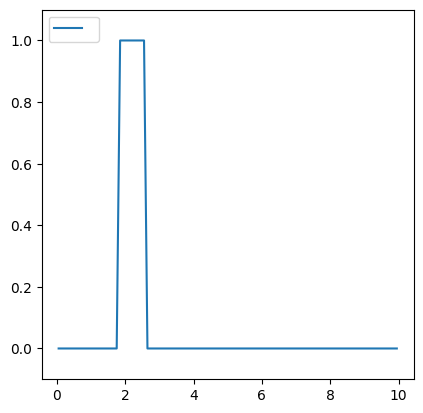

In [11]:
# ploting the unkown's initial distribution
viewer = Viewer(vars = (yInit),
                datamin = yInit.min()-.1,
                datamax = yInit.max()+.1)
viewer.plot()

After 0.29900000000000004  (sec)


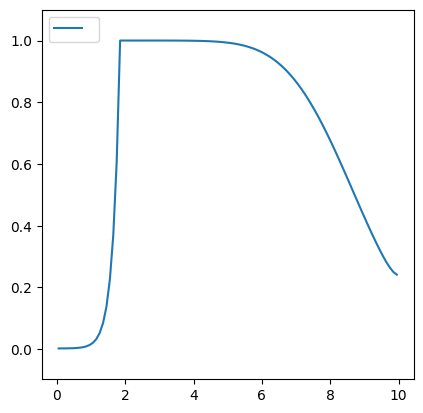

In [12]:
# ploting the unkown's final distribution
print('After', dt*stepsNbr, ' (sec)')
viewer = Viewer(vars = (y),
                datamin = y.min()-.1,
                datamax = y.max()+.1)
viewer.plot()